 Aum Sri Sairam

**generating Binary class MNIST dataset**

In [1]:
import torch
import scipy.io as sio
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data_utils

%matplotlib inline

In [2]:
X_train= sio.loadmat("./binaryClassDataset/trainData.mat")
y_train= sio.loadmat("./binaryClassDataset/trainlabes.mat")
x_test= sio.loadmat("./binaryClassDataset/testData.mat")
y_test= sio.loadmat("./binaryClassDataset/testLabels.mat")

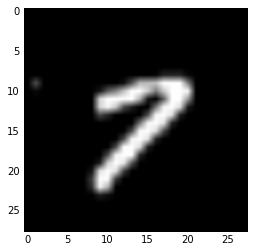

In [3]:
X= X_train["trainData"]
y= y_train["trainLabels"]
#y[y == 0] = -1
Xt= x_test["testData"]
yt= y_test["testLabels"]
#yt[yt == 0] = -1
#convert train and test data into toch tensor

#Normalize the data set
m = np.mean(X, axis = 1, keepdims = True)
sd = np.std(X, axis = 1, keepdims = True)
mt = np.mean(Xt, axis = 1, keepdims = True)
sd_t = np.std(Xt, axis = 1, keepdims = True)
X = (X - m) / (sd + 1e-8)
xt = (Xt - mt) / (sd_t + 1e-8)

X= torch.FloatTensor(X)
y= torch.Tensor(y)


xt= torch.FloatTensor(Xt) 
yt= torch.Tensor(yt)

plt.imshow(X[5].reshape(28, 28).transpose(1, 0), cmap = 'gray')

In [4]:
print(X.shape)
print(Xt.shape)

torch.Size([12396, 784])
(2038, 784)


** This is best way to use Dataloader on our owndata ** 

** Make Train Data Iterable **

In [5]:
train= data_utils.TensorDataset(X, y)
train_loader= data_utils.DataLoader(train, batch_size=32, shuffle= True)

** Make Test Data Iterable **

In [6]:
test= data_utils.TensorDataset(xt, yt)
test_loader= data_utils.DataLoader(test, batch_size=32)

In [7]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear= nn.Linear(input_dim, output_dim)
        self.sigmoid= nn.Sigmoid()
        
    def forward(self,x):
        out= self.linear(x)
        #return self.sigmoid(out)
        return out

In [8]:
input_dim= 28*28
output_dim= 1
batch_size= 32
classes= ("Three", "Seven")

In [9]:
model= LogisticRegression(input_dim, output_dim)

In [10]:
cuda= torch.cuda.is_available()

If GPU is available then port the model to GPU.

In [11]:
if cuda:
    model.cuda()

In [12]:
print(model)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [13]:
params= list(model.parameters())
params= params[0].cpu().detach().numpy()

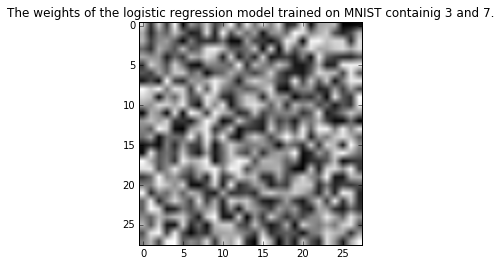

In [14]:
plt.title("The weights of the logistic regression model trained on MNIST containig 3 and 7.")
plt.imshow(params.reshape(-1,28).T, cmap='gray')

**Instantiate loss class, optimizer class and learning rate **

In [15]:
criterion= nn.BCEWithLogitsLoss()
learning_rate= 0.001
optimizer= torch.optim.SGD(model.parameters(), learning_rate, weight_decay = 0)

** Read Data in Batch **

In [21]:
def test(model, test_loader):
    correct= 0
    total= 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            #images, labels = images.cuda(), labels.cuda()
            output= model(images)
            output= np.where(output.cpu().detach().numpy() > 0.5,1,0)
        
            correct += (output == labels.data.long()).sum()
            total += labels.size(0)
        print("\nTest Accuracy: {0:.4f}\n---------------------------------\n".format((100. * correct.numpy()/total)))

In [22]:
def train(model, criterion, optimizer, epoch, train_loader):
    for i,(images,labels) in enumerate(train_loader):
        #images, labels = images.cuda(), labels.cuda()
        #images, labels= torch.tensor(torch.FloatTensor(images), requires_grad= False), labels
        optimizer.zero_grad()
        output= model(images)    
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        if (i)%100 == 0:
            print("Epoch {}, Iteration {} , training_loss {:.2f} " .format(epoch,i+1, loss.item()))

**Now train and test our model**

In [55]:
num_epochs= 200
for epoch in range(num_epochs):
    train(model, criterion, optimizer, epoch, train_loader)
    test(model, test_loader)

Epoch 0, Iteration 1 , training_loss 0.00 
Epoch 0, Iteration 101 , training_loss 0.01 
Epoch 0, Iteration 201 , training_loss 0.01 
Epoch 0, Iteration 301 , training_loss 0.00 

Test Accuracy: 97.8901
---------------------------------

Epoch 1, Iteration 1 , training_loss 0.00 
Epoch 1, Iteration 101 , training_loss 0.00 
Epoch 1, Iteration 201 , training_loss 0.00 
Epoch 1, Iteration 301 , training_loss 0.01 

Test Accuracy: 97.8901
---------------------------------

Epoch 2, Iteration 1 , training_loss 0.00 
Epoch 2, Iteration 101 , training_loss 0.02 
Epoch 2, Iteration 201 , training_loss 0.00 
Epoch 2, Iteration 301 , training_loss 0.03 

Test Accuracy: 97.8901
---------------------------------

Epoch 3, Iteration 1 , training_loss 0.02 
Epoch 3, Iteration 101 , training_loss 0.00 
Epoch 3, Iteration 201 , training_loss 0.01 
Epoch 3, Iteration 301 , training_loss 0.01 

Test Accuracy: 97.8901
---------------------------------

Epoch 4, Iteration 1 , training_loss 0.04 
Epoch 4, 

In [56]:
params= list(model.parameters())
params= params[0].cpu().detach().numpy()

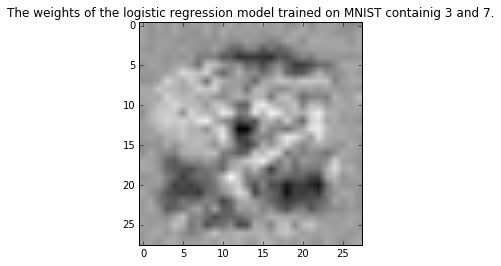

In [57]:
plt.title("The weights of the logistic regression model trained on MNIST containig 3 and 7.")
plt.imshow(params.reshape(-1,28).T, cmap='gray')

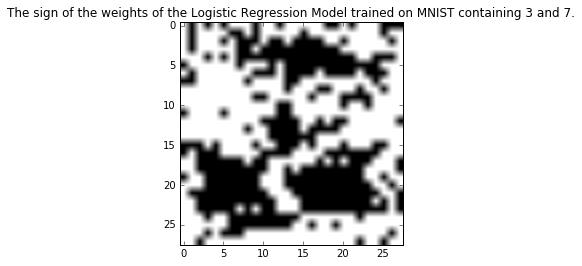

In [58]:
plt.title("The sign of the weights of the Logistic Regression Model trained on MNIST containing 3 and 7.")
sign_params= np.sign(params)
plt.imshow(sign_params.reshape(-1,28).T, cmap='gray')

In [69]:
def adversarial_attack(model,optimizer, criterion,epsilon= 0.1):
    correct= 0
    total= 0
    params = list(model.parameters())    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            
            #images, labels =  images.cuda(), labels.cuda()
            #==========================================================
            # PRINT FEW CLEAN IMAGES
            #==========================================================
            
            #images[images <= 0.4] = 0.5
            x_new= images
            index= 0

            x_new= x_new.cpu().detach().numpy()

            if i == 0:

                plt.subplot(2,2,1)
                plt.imshow(x_new[index].reshape(28,28).T, cmap='gray')
                plt.title("CLEAN IMAGES")

                plt.subplot(2,2,3)
                plt.imshow(x_new[index + 1].reshape(28,28).T, cmap='gray') 
            #==========================================================

            ''' optimizer.zero_grad()
            output= model(images)
            loss= criterion(output, labels)
            loss.backward()'''
            
            temp = torch.empty_like(labels)
            temp.copy_(labels)
            temp[temp == 0] = -1            
            x_grad= -temp * torch.sign(params[0].data)
            x_adv= torch.clamp(images + epsilon*x_grad, 0, 1)

            #==========================================================
            # PRINT FEW CLEAN IMAGES
            #==========================================================
            x_adv_new= x_adv.cpu().detach().numpy()

            if i == 0:


                plt.subplot(2,2,2)
                plt.imshow(x_adv_new[index].reshape(28,28).transpose(1,0), cmap='gray')
                plt.title("GRAD")

                plt.subplot(2,2,4)
                plt.imshow(x_adv_new[index + 1].reshape(28,28).transpose(1, 0), cmap='gray')


            #plt.show()
            #===========================================================

            adv_output= model(x_adv)
            adv_output[adv_output > 0.5]= 1
            adv_output[adv_output <= 0.5]= 0


            correct += (adv_output.data.long() == labels.data.long()).sum()
            total += labels.size(0)

        print("Epsilon: {} Adversarial Accuracy: {:.2f}".format(epsilon,100. * correct.numpy()/total))

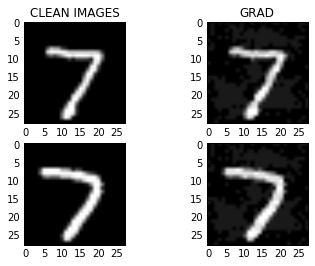

Epsilon: 0.1 Adversarial Accuracy: 29.98


In [60]:
adversarial_attack(model,optimizer, criterion)

In [61]:
epsilon=[0.01 * i for i in range(26)]

**Test our accuracy on for various epsilon values**

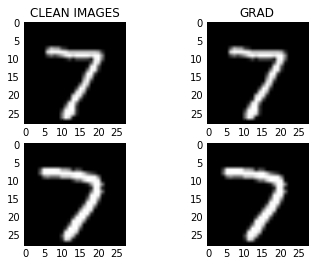

Epsilon: 0.0 Adversarial Accuracy: 97.89


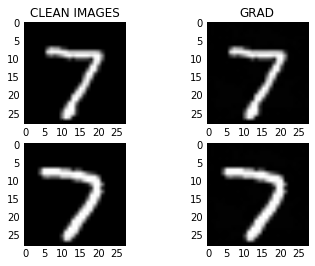

Epsilon: 0.01 Adversarial Accuracy: 96.32


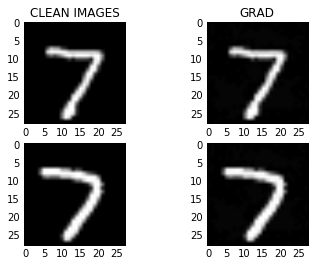

Epsilon: 0.02 Adversarial Accuracy: 93.62


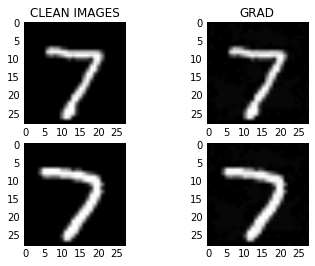

Epsilon: 0.03 Adversarial Accuracy: 89.25


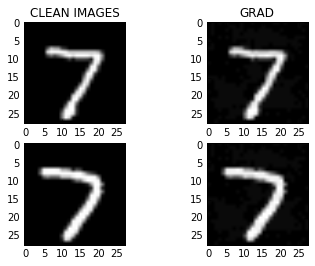

Epsilon: 0.04 Adversarial Accuracy: 81.26


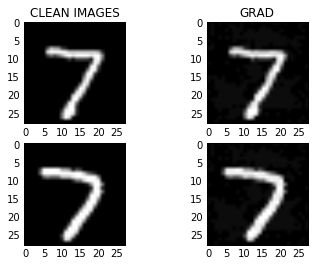

Epsilon: 0.05 Adversarial Accuracy: 71.64


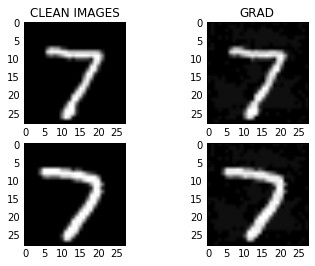

Epsilon: 0.06 Adversarial Accuracy: 61.19


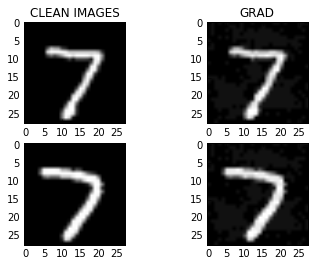

Epsilon: 0.07 Adversarial Accuracy: 51.77


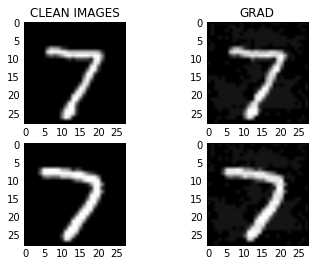

Epsilon: 0.08 Adversarial Accuracy: 43.47


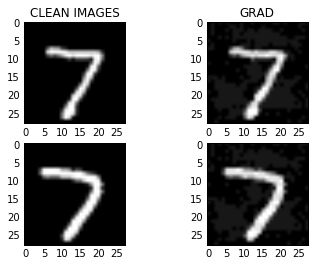

Epsilon: 0.09 Adversarial Accuracy: 35.97


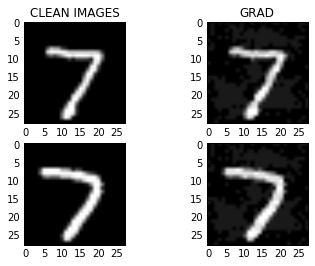

Epsilon: 0.1 Adversarial Accuracy: 29.98


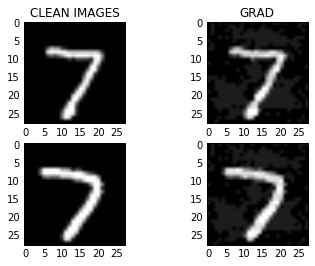

Epsilon: 0.11 Adversarial Accuracy: 23.50


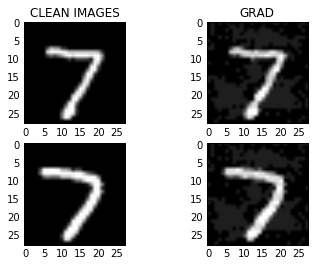

Epsilon: 0.12 Adversarial Accuracy: 17.76


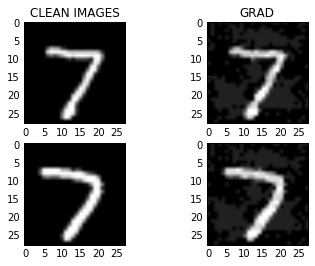

Epsilon: 0.13 Adversarial Accuracy: 13.30


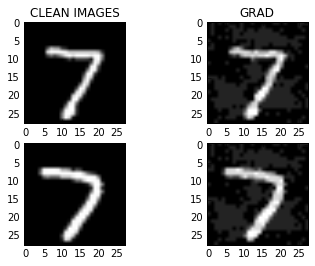

Epsilon: 0.14 Adversarial Accuracy: 9.37


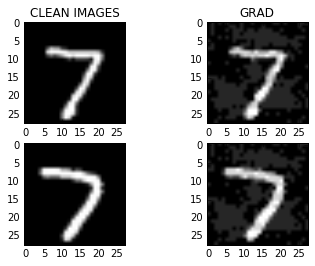

Epsilon: 0.15 Adversarial Accuracy: 7.11


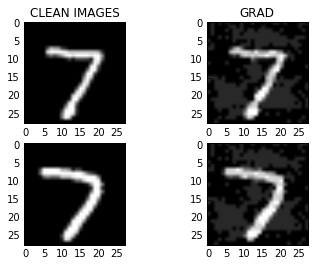

Epsilon: 0.16 Adversarial Accuracy: 4.66


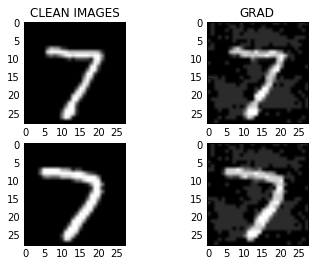

Epsilon: 0.17 Adversarial Accuracy: 3.29


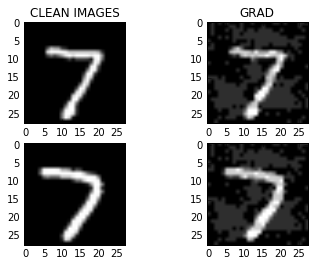

Epsilon: 0.18 Adversarial Accuracy: 1.96


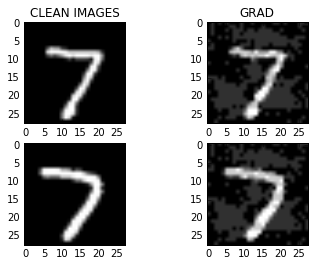

Epsilon: 0.19 Adversarial Accuracy: 0.98


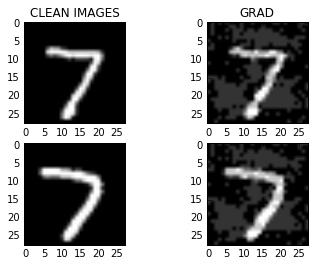

Epsilon: 0.2 Adversarial Accuracy: 0.34


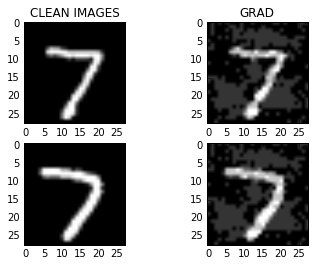

Epsilon: 0.21 Adversarial Accuracy: 0.15


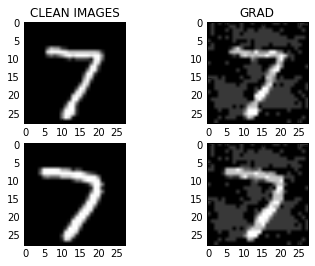

Epsilon: 0.22 Adversarial Accuracy: 0.05


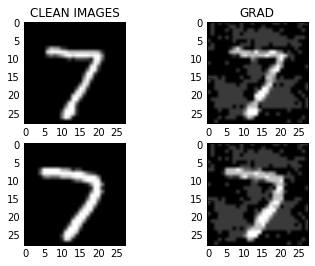

Epsilon: 0.23 Adversarial Accuracy: 0.05


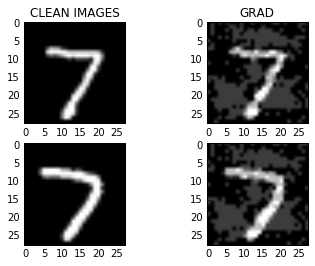

Epsilon: 0.24 Adversarial Accuracy: 0.05


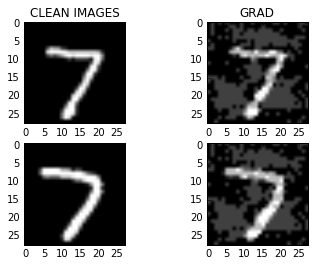

Epsilon: 0.25 Adversarial Accuracy: 0.00


In [62]:
for eps in epsilon:
    adversarial_attack(model, optimizer,criterion, eps)

In [63]:
torch.save(model.state_dict(),"adv_logistic_regression_final.pt")

In [64]:
model1= LogisticRegression(input_dim,output_dim)for eps in epsilon:
    adversarial_attack(model, optimizer,criterion, eps)

In [67]:
model1.load_state_dict(torch.load("adv_logistic_regression_final.pt"))

Epsilon: 0.0 Adversarial Accuracy: 97.89
Epsilon: 0.01 Adversarial Accuracy: 96.32
Epsilon: 0.02 Adversarial Accuracy: 93.62
Epsilon: 0.03 Adversarial Accuracy: 89.25
Epsilon: 0.04 Adversarial Accuracy: 81.26
Epsilon: 0.05 Adversarial Accuracy: 71.64
Epsilon: 0.06 Adversarial Accuracy: 61.19
Epsilon: 0.07 Adversarial Accuracy: 51.77
Epsilon: 0.08 Adversarial Accuracy: 43.47
Epsilon: 0.09 Adversarial Accuracy: 35.97
Epsilon: 0.1 Adversarial Accuracy: 29.98
Epsilon: 0.11 Adversarial Accuracy: 23.50
Epsilon: 0.12 Adversarial Accuracy: 17.76
Epsilon: 0.13 Adversarial Accuracy: 13.30
Epsilon: 0.14 Adversarial Accuracy: 9.37
Epsilon: 0.15 Adversarial Accuracy: 7.11
Epsilon: 0.16 Adversarial Accuracy: 4.66
Epsilon: 0.17 Adversarial Accuracy: 3.29
Epsilon: 0.18 Adversarial Accuracy: 1.96
Epsilon: 0.19 Adversarial Accuracy: 0.98
Epsilon: 0.2 Adversarial Accuracy: 0.34
Epsilon: 0.21 Adversarial Accuracy: 0.15
Epsilon: 0.22 Adversarial Accuracy: 0.05
Epsilon: 0.23 Adversarial Accuracy: 0.05
Epsil

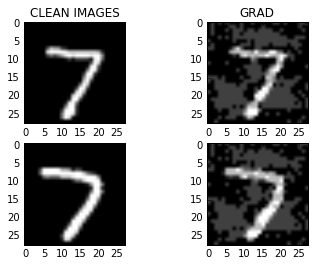

In [70]:
for eps in epsilon:
    adversarial_attack(model1, optimizer,criterion, eps)